[UK COVID-19 Dashboard](https://github.com/jmdwrntn/ukcovid19dashboard) (C) James Thornton, 2021 ([jmdwrntn@mailbox.org](mailto:jmdwrntn@mailbox.org)). All rights reserved.
 *Based on UK Government [data](https://coronavirus.data.gov.uk/) published by [Public Health England](https://www.gov.uk/government/organisations/public-health-england).*

# DIY Covid-19 Dashboard

This is a template for your DIY Covid Dashboard, to which you can add the code you developed in the previous notebooks. The dashboard will be displayed using [voila](https://voila.readthedocs.io/en/stable/index.html), a Python dashboarding tool that converts notebooks to standalone dashboards. Contrary to the other libraries we have seen, the ```voila``` package must be installed using *pip* or *conda* but it does not need to be imported - it rather acts at the level of the notebook server. Package ```voila``` is already installed on the EECS JupyterHub as well as in the binder - to install it locally, follow the [instructions](https://voila.readthedocs.io/en/stable/install.html) online.

Broadly speaking, Voila acts by **running all the cells in your notebook** when the dashboard is first loaded; it then hides all code cells and displays all markdown cells and any outputs, including widgets. However, the code is still there in the background and handles any interaction with the widgets. To view this dashboard template rendered in Voila click [here](https://mybinder.org/v2/gh/fsmeraldi/diy-covid19dash/main?urlpath=%2Fvoila%2Frender%2FDashboard.ipynb).

In [2]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from uk_covid19 import Cov19API

In [3]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

## Load initial data from disk

You should include "canned" data in ```.json``` files along with your dashboard. When the dashboard starts, it should load that data (the code below will be hidden when the dashboard is rendered by Voila).

In [12]:
# Load JSON files and store the raw data in some variable. Edit as appropriate
with open("beds.json", "rt") as INFILE:
    jsondata=json.load(INFILE)

## Wrangle the data

The dashboard should contain the logic to wrangle the raw data into a ```DataFrame``` (or more than one, as required) that will be used for plotting. The wrangling code should be put into a function and called on the data from the JSON file (we'll need to call it again on any data downloaded from the API).  In this template, we just pretend we are wrangling ```rawdata``` and generate a dataframe with some random data

In [13]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

<AxesSubplot:>

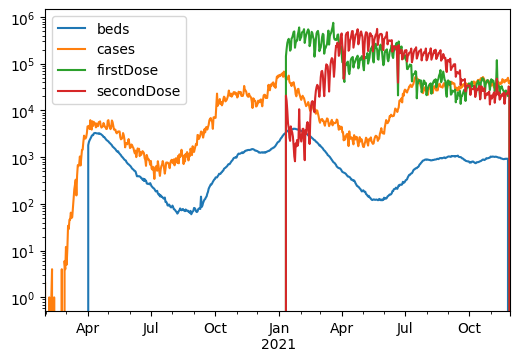

In [39]:
def wrangle_data(rawdata):
    """ Parameters: rawdata - data from json file or API call. Returns a dataframe.
    Edit to include the code that wrangles the data, creates the dataframe and fills it in. """
    
    datalist=rawdata['data']
    dates=[dictionary['date'] for dictionary in datalist ]
    dates.sort()
    startdate=parse_date(dates[0])
    enddate=parse_date(dates[-1])   

    index=pd.date_range(startdate, enddate, freq='D')
    df=pd.DataFrame(index=index, columns=['beds', 'cases', 'firstDose', 'secondDose'])

    for entry in datalist: # each entry is a dictionary with date, cases, hospital and deaths
        parsed_date=parse_date(entry['date'])
        for column in ['beds', 'cases', 'firstDose', 'secondDose']:
        # check that nothing is there yet - just in case some dates are duplicated,
        # maybe with data for different columns in each entry
            if pd.isna(df.loc[parsed_date, column]): 
            # replace None with 0 in our data 
                value=float(entry[column]) if entry[column]!=None else 0.0
            # this is the way you access a specific location in the dataframe - use .loc
            # and put index,column in a single set of [ ]
                df.loc[parsed_date, column]=value
            
    # fill in any remaining "holes" due to missing dates
    df.fillna(0.0, inplace=True)

    return df

# putting the wrangling code into a function allows you to call it again after refreshing the data through 
# the API. You should call the function directly on the JSON data when the dashboard starts, by including 
# the call in the cell as below:
# df=wrangle_data(jsondata) # df is the dataframe for plotting
# df.plot(logy=True)

df=wrangle_data(jsondata)

## Download current data

Give your users an option to refresh the dataset - a "refresh" button will do. The button callback should
* call the code that accesses the API and download some fresh raw data;
* wrangle that data into a dataframe and update the corresponding (global) variable for plotting;
* optionally: force a redraw of the graph and give the user some fredback.

Once you get it to work, you may want to wrap your API call inside an exception handler, so that the user is informed, the "canned" data are not overwritten and nothing crashes if for any reason the server cannot be reached or data are not available.

After you refresh the data, graphs will not update until the user interacts with a widget. You can trick ```iPywidgets``` into redrawing the graph by simulating interaction, as in the ```refresh_graph``` function we define in the Graph and Analysis section below.

Clicking on the button below just generates some more random data and refreshes the graph. The button should read *Fetch Data*. If you see anything else, take a deep breath :)

In [89]:
filters = [
    "areaType=overview"
]

structure = {
    "date": "date",
    "beds": "covidOccupiedMVBeds",
    "cases": "newCasesByPublishDate",
    "firstDose": "newPeopleVaccinatedFirstDoseByPublishDate",
    "secondDose": "newPeopleVaccinatedSecondDoseByPublishDate"
}

api = Cov19API(filters=filters, structure=structure)

In [90]:
# Place your API access code in this function. Do not call this function directly; it will be called by 
# the button callback. 
def access_api():
    """ Accesses the PHE API. Returns raw data in the same format as data loaded from the "canned" JSON file. """
    return api.get_json() # return data read from the API

In [106]:
# Printout from this function will be lost in Voila unless captured in an
# output widget - therefore, we give feedback to the user by changing the 
# appearance of the button
def api_button_callback(button):
    """ Button callback - it must take the button as its parameter (unused in this case).
    Accesses API, wrangles data, updates global variable df used for plotting. """
    # Get fresh data from the API. If you have time, include some error handling
    # around this call.
    apidata=access_api()
    
    if len(apidata) > 0:
        button.icon="check-circle"
        button.description="Synced"
        button.style='success'
        button.disabled=True
        global df
        df=wrangle_data(apidata)
        refresh_graph()
    else:
        button.icon="exclamation-circle"
        button.description="Error"
        button.style="warning"
        button.tooltip="Could not sync latest data, falling back to current data"
    # wrangle the data and overwrite the dataframe for plotting
    
    # the graph won't refresh until the user interacts with the widget.
    # this function simulates the interaction, see Graph and Analysis below.
    # you can omit this step in the first instance
    # refresh_graph()
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again. You can use icons
    # "unlink" or "times" and change the button text to "Unavailable" in case the 
    # api call fails.
    # apibutton.icon="check"
    # apibutton.disabled=True

    
apibutton=wdg.Button(
    description='Sync data', # you may want to change this...
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Sync latest data from PHE",
    # FontAwesome names without the `fa-` prefix - try "download"
    icon='cloud-download'
)

# remember to register your button callback function with the button
apibutton.on_click(api_button_callback) # the name of your function inside these brackets

display(apibutton)


# run all cells before clicking on this button

Button(description='Sync data', icon='cloud-download', style=ButtonStyle(), tooltip='Sync latest data from PHE…

## Graphs and Analysis

Include at least one graph with interactive controls, as well as some instructions for the user and/or comments on what the graph represents and how it should be explored (this example shows two random walks)

In [118]:
bedcols=wdg.SelectMultiple(
    options=['beds', 'cases', 'firstDose', 'secondDose'], # options available
    value=['beds', 'cases', 'firstDose'], # initial value
    rows=4, # rows of the selection box
    description='Options',
    disabled=False
)

def refresh_graph():
    current=bedcols.value
    if current==bedcols.options[0:2]:
        other=bedcols.options[0:3]
    else:
        other=bedcols.options[0:2]
    bedcols.value=other
    bedcols.value=current

def beds_graph(graphcolumns):
    # our callback function.
    ncols=len(graphcolumns)
    if ncols>0:
        df.plot(logy=True, y=list(graphcolumns)) # graphcolumns is a tuple - we need a list
        plt.title("UK COVID-19: Occupied Beds, Cases and Vaccinations by Dosage")
        plt.xlabel("Month")
        plt.ylabel("Number of people")
        plt.show() # important - graphs won't update properly if this is missing
    else:
        # if the user has not selected any column, print a message instead
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")
    
# keep calling beds_graph(graphcolumns=value_of_bedcols); capture output in widget output    
output=wdg.interactive_output(beds_graph, {'graphcolumns': bedcols})

graph=wdg.HBox([output, bedcols])
display(graph)

#display(bedcols, output)

## Deploying the dashboard

Once your code is ready and you are satisfied with the appearance of the graphs, replace all the text boxes above with the explanations you would like a dashboard user to see. The next step is deploying the dashboard online - there are several [options](https://voila.readthedocs.io/en/stable/deploy.html) for this, we suggest deploying as a [Binder](https://mybinder.org/). This is basically the same technique that has been used to package this tutorial and to deploy this template dashboard. The instructions may seem a bit involved, but the actual steps are surprisingly easy - we will be going through them together during a live session. You will need an account on [GitHub](https://github.com/) for this - if you don't have one already, now it's the time to create it. 

**Author and Copyright Notice** Remember if you deploy this dashboard as a Binder it will be publicly accessible. Take credit for your work! Also acknowledge the data source: *Based on UK Government [data](https://coronavirus.data.gov.uk/) published by [Public Health England](https://www.gov.uk/government/organisations/public-health-england).*